In [ ]:
!pip install qiskit qiskit-machine-learning
!pip install qiskit qiskit-machine-learning qiskit-algorithms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 28.4 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings


from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from qiskit_algorithms.optimizers import COBYLA



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:04<00:00, 16.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


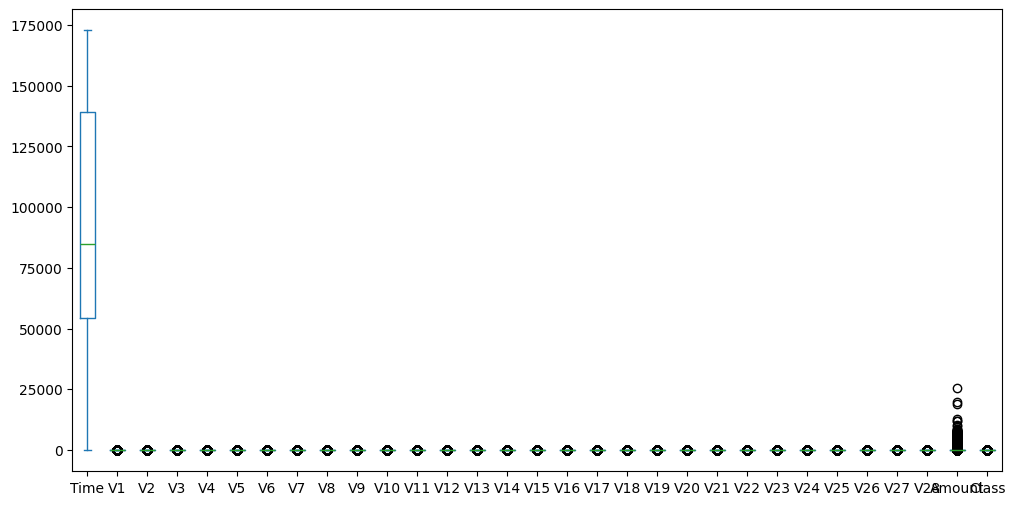

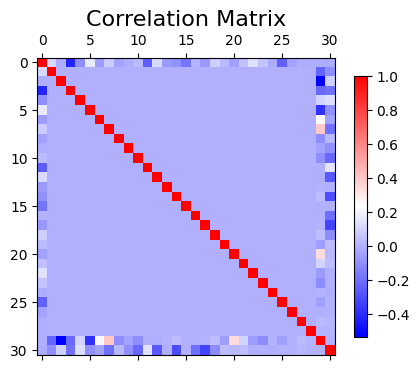

In [ ]:
import os

# Load dataset (assuming the CSV is inside the downloaded path)
csv_path = os.path.join(path, "creditcard.csv")
data = pd.read_csv(csv_path)

# Now your plotting code will work
data.plot.box(figsize=(12,6))
plt.show()

plt.matshow(data.corr(), cmap='bwr')
cb = plt.colorbar(shrink=0.7)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


In [ ]:
normal = data[data.Class==0] # Set of all normal (y = 0) cases
fraud = data[data.Class==1]  # Set of all fraud (y = 1) cases


num_normal = normal.shape[0]
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 284315
Number of fraud examples = 492

normal to fraud ratio in the whole data = 577.88


In [ ]:
normal_fraud_ratio = 1                                      # normal_fraud_ratio = 1 means balance sample
normal_sample = normal.sample(normal_fraud_ratio*num_fraud)


# joining row-wise (axis=0) normal and fraud cases to get a sample
sample = pd.concat([fraud, normal_sample], axis=0)


for i in range(100):
    sample = np.random.permutation(sample)                   # random shuffling of sample examples 100 times



#==============================================================================


X, y = sample[:, :-1], sample[:, -1]

X = MinMaxScaler().fit_transform(X)            # this will put all the feature (X) values in the interval [0,1]

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)


X[:3,:], y[:3]

number of examples =  984
number of features =  30


(array([[0.37177425, 0.96151207, 0.47974136, 0.89173337, 0.38320318,
         0.55440923, 0.5631924 , 0.824746  , 0.6763291 , 0.67905467,
         0.76124299, 0.30931711, 0.85941719, 0.11716659, 0.77596546,
         0.72210371, 0.90074703, 0.83869895, 0.80345879, 0.23716586,
         0.55678332, 0.45548295, 0.50602441, 0.60402974, 0.62433042,
         0.53193045, 0.31546336, 0.62662021, 0.19018593, 0.        ],
        [0.96677446, 0.95034633, 0.48803718, 0.82626686, 0.27227298,
         0.54082546, 0.51013503, 0.82550476, 0.67756619, 0.6825779 ,
         0.78352309, 0.26177221, 0.97702721, 0.6850446 , 0.90667969,
         0.74949221, 0.74831205, 0.81005545, 0.72590038, 0.6989572 ,
         0.5581612 , 0.46355717, 0.5713965 , 0.61255305, 0.67599   ,
         0.46654685, 0.42187144, 0.5716573 , 0.16114983, 0.00405934],
        [0.37394555, 0.97149596, 0.44013083, 0.91866167, 0.1481934 ,
         0.51862661, 0.56901129, 0.80578754, 0.672286  , 0.70473022,
         0.7852113 , 0.10105081,

In [ ]:
n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (5, 32)
number of examples =  984
number of features =  32


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)

(688, 32) (296, 32)


In [ ]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap


fm = ZZFeatureMap(feature_dimension=num_features, reps=1)                   # ZZFeatureMap seems better
fm.decompose().draw()

┌───┐┌─────────────┐                                                »
 q_0: ┤ H ├┤ P(2.0*x[0]) ├───■────────────────────────────────────■────■──»
      ├───┤├─────────────┤ ┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
 q_1: ┤ H ├┤ P(2.0*x[1]) ├─┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
      ├───┤├─────────────┤ └───┘└──────────────────────────────┘└───┘┌─┴─┐»
 q_2: ┤ H ├┤ P(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
      ├───┤├─────────────┤                                           └───┘»
 q_3: ┤ H ├┤ P(2.0*x[3]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_4: ┤ H ├┤ P(2.0*x[4]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_5: ┤ H ├┤ P(2.0*x[5]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_6: ┤ H ├┤ P(2.0*x[6]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_7: ┤ H ├┤ P(2.0*x[7]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_8: ┤ H ├┤ P(2.0*x[8]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_9: ┤ H ├┤ P(2.0*x[9]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┴┐                                               »
q_10: ┤ H ├┤ P(2.0*x[10]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_11: ┤ H ├┤ P(2.0*x[11]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_12: ┤ H ├┤ P(2.0*x[12]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_13: ┤ H ├┤ P(2.0*x[13]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_14: ┤ H ├┤ P(2.0*x[14]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_15: ┤ H ├┤ P(2.0*x[15]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_16: ┤ H ├┤ P(2.0*x[16]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_17: ┤ H ├┤ P(2.0*x[17]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_18: ┤ H ├┤ P(2.0*x[18]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_19: ┤ H ├┤ P(2.0*x[19]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_20: ┤ H ├┤ P(2.0*x[20]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_21: ┤ H ├┤ P(2.0*x[21]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_22: ┤ H ├┤ P(2.0*x[22]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_23: ┤ H ├┤ P(2.0*x[23]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_24: ┤ H ├┤ P(2.0*x[24]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_25: ┤ H ├┤ P(2.0*x[25]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                           

In [ ]:
from qiskit_machine_learning.circuit.library import RawFeatureVector


fm = RawFeatureVector(feature_dimension=num_features)
fm.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_1: ┤1                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_2: ┤2 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31]) ├
«     │                                                                                                                                                                                                                 │
«q_3: ┤3                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_4: ┤4                                                                                                                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [ ]:
from qiskit.circuit.library import RealAmplitudes


'''
For angle encoding, num_qubits = num_features
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps=3)
pqc.decompose().draw()

┌──────────┐                                          ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────────────────────────────■───────┤ Ry(θ[5]) ├»
     ├──────────┤                                ┌─┴─┐     ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──────────────────────■─────────┤ X ├─────┤ Ry(θ[6]) ├»
     ├──────────┤                    ┌─┴─┐    ┌──┴───┴───┐ └──────────┘»
q_2: ┤ Ry(θ[2]) ├──────────■─────────┤ X ├────┤ Ry(θ[7]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_3: ┤ Ry(θ[3]) ├──■─────┤ X ├────┤ Ry(θ[8]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_4: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[9]) ├───────────────┤ X ├────┤ Ry(θ[14]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                               ┌───────────┐                          »
«q_0: ───────────────────■──────┤ Ry(θ[10]) ├───────────────────■──────»
«                      ┌─┴─┐    ├───────────┤                 ┌─┴─┐    »
«q_1: ──────■──────────┤ X ├────┤ Ry(θ[11]) ├──────■──────────┤ X ├────»
«         ┌─┴─┐    ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐»
«q_2: ────┤ X ├────┤ Ry(θ[12]) ├──────■──────────┤ X ├────┤ Ry(θ[17]) ├»
«     ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘»
«q_3: ┤ Ry(θ[13]) ├──────■──────────┤ X ├────┤ Ry(θ[18]) ├─────────────»
«     └───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘             »
«q_4: ─────────────────┤ X ├────┤ Ry(θ[19]) ├──────────────────────────»
«                      └───┘    └───────────┘                          »
«     ┌───────────┐
«q_0: ┤ Ry(θ[15]) ├
«     ├───────────┤
«q_1: ┤ Ry(θ[16]) ├
«     └───────────┘
«q_2: ─────────────
«                  
«q_3: ─────────────
«                  
«q_4: ─────────────
«

In [ ]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

optimizer = COBYLA(maxiter=150)
sampler = Sampler()

from IPython.display import clear_output
import matplotlib.pyplot as plt

objective_func_vals = []
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,   # make sure you defined `pqc` (your variational ansatz)
    optimizer=optimizer,
    callback=callback,
)


/tmp/ipython-input-1101923880.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [ ]:
# --- RERUN THIS CELL AFTER THE DATA LOADING CELLS ---

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming 'sample' is the concatenated and shuffled NumPy array from your earlier steps
# If 'sample' is still a pandas DataFrame, convert it: sample = sample.values

# 1. Separate features (X) and target (y)
X, y = sample[:, :-1], sample[:, -1] # X has 30 columns

# 2. Define and Fit the Scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)            # X is now scaled (still 30 columns)

# 3. Apply Padding to X
num_features = X.shape[1]  # Should be 30
n = int(np.ceil(np.log2(num_features))) # Should be 5
dim = 2**n                 # Should be 32

zeros = np.zeros((X.shape[0], dim - num_features))
X = np.append(X, zeros, axis=1) # X is now padded to 32 features

# 4. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f"Scaler object is now defined as: {scaler}")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Scaler object is now defined as: MinMaxScaler()
X_train shape: (688, 32), X_test shape: (296, 32)


In [ ]:
# ... (Cell defining feature_map 'fm', ansatz 'pqc', and optimizer/sampler) ...

# (Your cell defining and training the VQC model, where it creates the 'vqc' object)
# ...

# This line MUST run to make 'vqc' available for the frontend!
vqc.fit(X_train, y_train)

In [ ]:
# Save the trained VQC model using the built-in .save() method

import time
import os

# Define the filename with the training time
timestamp = time.strftime("%Y%m%d_%H%M%S")
# Qiskit saves to a .json file format
filename = f'vqc_fraud_model_{timestamp}.json'

# Check if the model exists before trying to save
if 'vqc' in locals():
    # Use the VQC's native save method
    vqc.save(filename)

    print(f"✅ VQC model successfully saved to: {filename}")
    print(f"You can find this file in the Colab 'Files' sidebar (folder icon).")
else:
    print("❌ Error: The 'vqc' model object is not defined. Ensure the training cell ran without errors.")

✅ VQC model successfully saved to: vqc_fraud_model_20251023_070740.json
You can find this file in the Colab 'Files' sidebar (folder icon).


In [ ]:
# Load the VQC model using the built-in .load() method

from qiskit_machine_learning.algorithms.classifiers import VQC # Import the class

# 🚨 CHANGE THIS FILENAME to the exact name saved above 🚨
load_filename = 'C:\Users\ramdw\Desktop\Credit Card Fraud detection Using QML\vqc_fraud_model_20251023_070740.json'

try:
    # Use the VQC's native load method
    vqc = VQC.load(load_filename)
    print(f"✅ VQC model successfully loaded from: {load_filename}")

except FileNotFoundError:
    print(f"❌ Error: The file '{load_filename}' was not found.")
except Exception as e:
    print(f"❌ An error occurred during loading: {e}")

✅ VQC model successfully loaded from: /content/vqc_fraud_model_20251023_070740.json


In [ ]:
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89       338
         1.0       0.99      0.77      0.86       350

    accuracy                           0.88       688
   macro avg       0.90      0.88      0.88       688
weighted avg       0.90      0.88      0.88       688

[[336   2]
 [ 82 268]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       154
         1.0       0.98      0.85      0.91       142

    accuracy                           0.92       296
   macro avg       0.92      0.91      0.91       296
weighted avg       0.92      0.92      0.91       296

[[151   3]
 [ 22 120]] = confusion matrix for test set 
 
0.91 = roc_auc_score for test set 



In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import time
from sklearn.preprocessing import MinMaxScaler
# Note: MinMaxScaler is only imported here, but the object 'scaler'
# must be created in an earlier cell.

# ----------------------------------------------------------------------
# 1. Prediction Function
# ----------------------------------------------------------------------

# --- CORRECTED PREDICT_FRAUD FUNCTION ---

def predict_fraud(raw_input_features, scaler):
    """
    Takes 30 raw features, scales them, pads them to 32, and returns VQC prediction.
    """
    # 1. Convert list (30 features) to NumPy array (1, 30)
    X_new = np.array([raw_input_features])

    # 2. Normalize the data using the *fitted* scaler
    try:
        X_scaled = scaler.transform(X_new)
    except Exception as e:
        return f"Error during scaling: {e}", 'black', 0.00

    # 3. Apply Padding: Append 2 zeros (to make it 32 features)
    padding_size = 32 - X_scaled.shape[1]
    X_padded = np.append(X_scaled, np.zeros((1, padding_size)), axis=1)

    # 4. Make prediction
    start_time = time.time()

    # --- FIX APPLIED HERE: REMOVE [0] INDEXING ---
    prediction = vqc.predict(X_padded)
    # vqc.predict(X_padded) for a single input returns the prediction directly,
    # e.g., np.array(1.0) or np.array(0.0). We convert it to a simple float.
    prediction = float(prediction)
    # ---------------------------------------------

    elapsed_time = time.time() - start_time

    # 5. Determine result format
    if prediction == 1.0:
        result = 'FRAUDULENT (Class 1)'
        color = 'red'
    else:
        result = 'NORMAL (Class 0)'
        color = 'green'

    return result, color, elapsed_time

# --- END CORRECTED PREDICT_FRAUD FUNCTION ---


# ----------------------------------------------------------------------
# 2. Interactive Frontend Widgets
# ----------------------------------------------------------------------

style = {'description_width': 'initial'}

# Features for a targeted demonstration (using indexes 0, 10, 11, 12, 14, 17, 29)
# Assuming a standard creditcard.csv column order after dropping 'Class'.
# Index 0: Time, Index 29: Amount

Time_input = widgets.BoundedIntText(min=0, max=180000, step=1, value=100000,
                                    description='Time (Index 0):', style=style)
Amount_input = widgets.BoundedFloatText(min=0, max=1000, step=1, value=100.0,
                                        description='Amount (Index 29):', style=style)

# Highly correlated V-features (Indices 10, 11, 12, 14, 17 are V10, V11, V12, V14, V17)
V10_input = widgets.BoundedFloatText(min=-20, max=5, step=0.1, value=-10.0,
                                     description='V10 (Index 10):', style=style)
V11_input = widgets.BoundedFloatText(min=-5, max=5, step=0.1, value=2.0,
                                     description='V11 (Index 11):', style=style)
V12_input = widgets.BoundedFloatText(min=-20, max=5, step=0.1, value=-10.0,
                                     description='V12 (Index 12):', style=style)
V14_input = widgets.BoundedFloatText(min=-25, max=5, step=0.1, value=-10.0,
                                     description='V14 (Index 14):', style=style)
V17_input = widgets.BoundedFloatText(min=-30, max=5, step=0.1, value=-15.0,
                                     description='V17 (Index 17):', style=style)

predict_button = widgets.Button(description='Run Quantum VQC Prediction',
                                button_style='danger', style=style)

output_area = widgets.Output()


# ----------------------------------------------------------------------
# 3. Event Handler
# ----------------------------------------------------------------------

def on_button_clicked(b):
    with output_area:
        output_area.clear_output()

        # Initialize 30 features to 0.0
        raw_features_list = [0.0] * 30

        # Map input widget values to their correct index (0-29)
        raw_features_list[0] = Time_input.value    # Time (Index 0)
        raw_features_list[29] = Amount_input.value # Amount (Index 29)

        raw_features_list[10] = V10_input.value
        raw_features_list[11] = V11_input.value
        raw_features_list[12] = V12_input.value
        raw_features_list[14] = V14_input.value
        raw_features_list[17] = V17_input.value

        # Run prediction
        result, color, elapsed_time = predict_fraud(raw_features_list, scaler)

        # Display the result
        html_output = f"<h3 style='color:{color};'>PREDICTION: {result}</h3>"
        display(HTML(html_output))
        print(f"Prediction Time: {elapsed_time:.4f} seconds (on simulator)")


# Attach the function to the button click event
predict_button.on_click(on_button_clicked)

# Display the final layout
input_form = widgets.VBox([
    widgets.Label(value='Enter Transaction Features (Raw Values)'),
    widgets.Label(value='(Remaining 23 V-Features are set to 0.0)'),
    Time_input,
    Amount_input,
    V10_input,
    V11_input,
    V12_input,
    V14_input,
    V17_input,
    predict_button
])

display(input_form, output_area)

Output()